# OBJECTIVE:
The comparison of guilty or innocent predictions is being made using classical logistic regression and quantum support vector machine (QSVC) models on a randomly generated dataset. The following steps are being followed in this comparison:

## 1- Dataset Creation:
Two different randomly generated datasets, data_gercek and data_mahkeme, are being created.
These datasets contain information such as individuals' identification details, citizenships, genders, types of crimes, and whether they are actual criminals or not.
## 2-Data Preparation:
Categorical variables are being converted into numerical values.
Missing values are being filled.
Training and test datasets are being created.
## 3-Data Scaling:
The training and test data are being subjected to standard scaling.
## 4-Classical Logistic Regression Model:
The classical logistic regression model is being trained using the training data.
Predictions are made on the training and test datasets, and accuracy rates are calculated.
## 5-Quantum Kernel and QSVC Model:
A quantum kernel is being created, and the QSVC model is being trained.
Predictions are made on the training and test datasets, and accuracy rates are calculated.
## 6-Predictions for the Entire Dataset:
Predictions are being made on the entire dataset using both classical and quantum models.
## 7-Confusion Matrices and Heatmaps:
Confusion matrices are being created and visualized for both classical and quantum models.
## 8-Visualization of Accuracy Rates:
The training and test accuracy rates are added to a DataFrame, visualized, and printed.

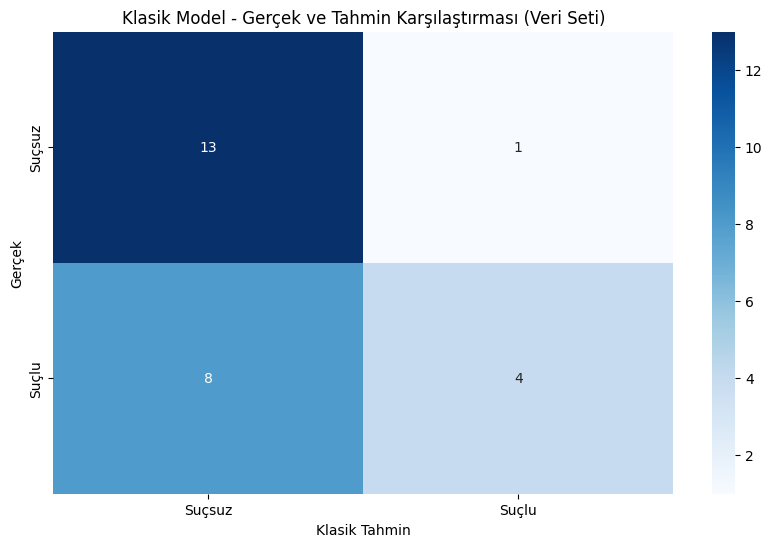

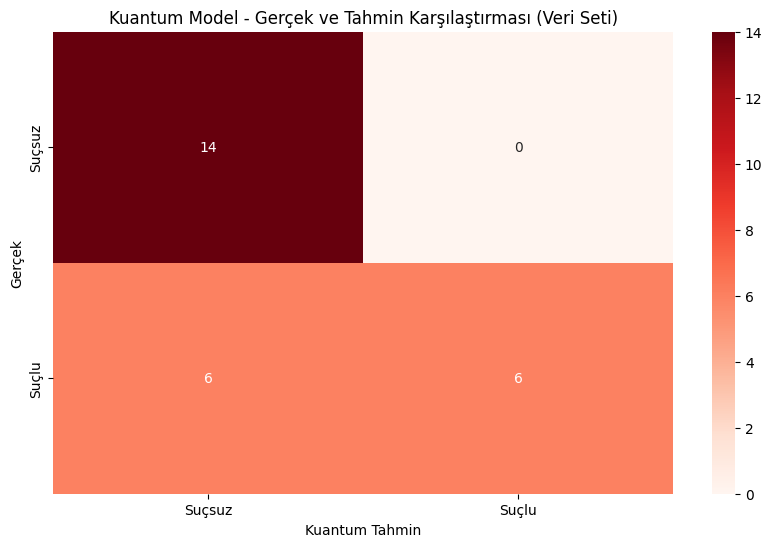

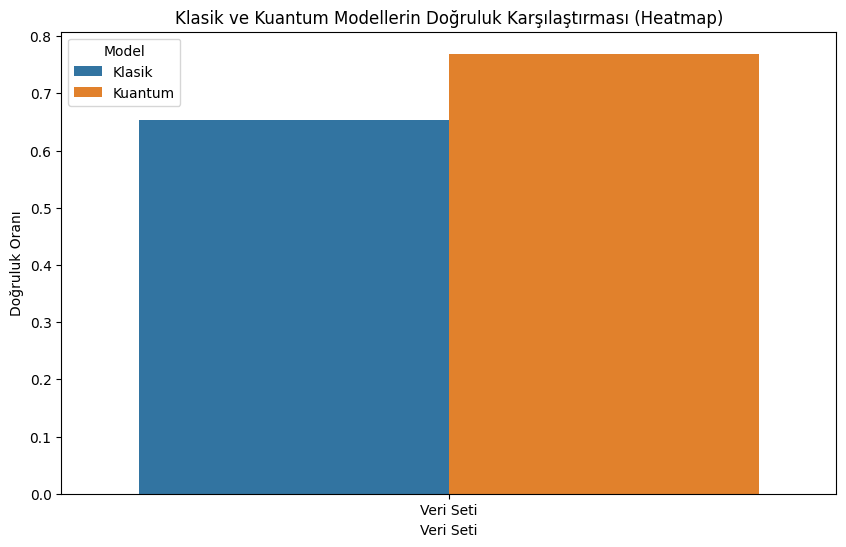

Classical Model Accuracy : 65.38%
Quantum Model Accuracy : 76.92%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

np.random.seed(42)

# Dataset size
n = 26

# Generating random dataset (real)
data_gercek = {
    'id': range(1, n + 1),
    'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
    'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
    'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
    'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
    'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
    'gercek_suclu': np.random.choice([0, 1], n)
}

# Generating random dataset (court)
data_mahkeme = {
    'id': range(1, n + 1),
    'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
    'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
    'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
    'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
    'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
    'mahkeme_karari': np.random.choice([0, 1], n)  # 0: Suçsuz, 1: Suçlu
}

df_gercek = pd.DataFrame(data_gercek)
df_mahkeme = pd.DataFrame(data_mahkeme)

# Converting categorical variables to numerical values
combined_df = pd.concat([df_mahkeme, df_gercek])
combined_encoded = pd.get_dummies(combined_df, columns=['vatandaslik', 'cinsiyet', 'suc'], drop_first=True)

# DataFrame'leri ayırma
df_mahkeme_encoded = combined_encoded.iloc[:n]
df_gercek_encoded = combined_encoded.iloc[n:]

# Filling missing values
df_mahkeme_encoded = df_mahkeme_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
df_gercek_encoded = df_gercek_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Creating training and test datasets
X_train, X_test, y_train, y_test = train_test_split(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu']), df_mahkeme_encoded['mahkeme_karari'], test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the classical logistic regression model
classic_model = LogisticRegression()
classic_model.fit(X_train_scaled, y_train)

# Classical model predictions
y_pred_train_classic = classic_model.predict(X_train_scaled)
y_pred_test_classic = classic_model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy_classic = accuracy_score(y_train, y_pred_train_classic)
test_accuracy_classic = accuracy_score(y_test, y_pred_test_classic)

# Quantum kernel creation
feature_dim = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

# Training the QSVC Model
quantum_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map)
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train_scaled, y_train)

# Making Predictions with the Quantum Model
y_pred_train_quantum = qsvc.predict(X_train_scaled)
y_pred_test_quantum = qsvc.predict(X_test_scaled)

# Calculating Accuracy with the Quantum Model
train_accuracy_quantum = accuracy_score(y_train, y_pred_train_quantum)
test_accuracy_quantum = accuracy_score(y_test, y_pred_test_quantum)

# Making Predictions for the Dataset
y_pred_all_classic = classic_model.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))
y_pred_all_quantum = qsvc.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))

# Confusion Matrix and Heatmap for the Classical Model
conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_all_classic, annot=True, fmt='d', cmap='Blues', xticklabels=['Suçsuz', 'Suçlu'], yticklabels=['Suçsuz', 'Suçlu'])
plt.title('Klasik Model - Gerçek ve Tahmin Karşılaştırması (Veri Seti)')
plt.xlabel('Klasik Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Confusion Matrix and Heatmap for the Quantum Model
conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_all_quantum, annot=True, fmt='d', cmap='Reds', xticklabels=['Suçsuz', 'Suçlu'], yticklabels=['Suçsuz', 'Suçlu'])
plt.title('Kuantum Model - Gerçek ve Tahmin Karşılaştırması (Veri Seti)')
plt.xlabel('Kuantum Tahmin')
plt.ylabel('Gerçek')
plt.show()
# Confusion matrix for classical model
conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)

# Confusion matrix for quantum model
conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)

# Calculating accuracy rates
def calculate_accuracy(conf_matrix):
    true_positives = conf_matrix[1, 1]
    true_negatives = conf_matrix[0, 0]
    total_samples = conf_matrix.sum()
    accuracy = (true_positives + true_negatives) / total_samples
    return accuracy

# Classical model accuracy rate
classic_accuracy = calculate_accuracy(conf_matrix_all_classic)

# Quantum model accuracy rate
quantum_accuracy = calculate_accuracy(conf_matrix_all_quantum)

# Adding accuracy rates to a DataFrame
accuracy_results_heatmap = {
    'Data': ['Veri Seti', 'Veri Seti'],
    'Accuracy': [classic_accuracy, quantum_accuracy],
    'Model': ['Klasik', 'Kuantum']
}
accuracy_df_heatmap = pd.DataFrame(accuracy_results_heatmap)

# Doğruluk oranlarını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='Data', y='Accuracy', hue='Model', data=accuracy_df_heatmap)
plt.title('Klasik ve Kuantum Modellerin Doğruluk Karşılaştırması (Heatmap)')
plt.ylabel('Doğruluk Oranı')
plt.xlabel('Veri Seti')
plt.show()

print(f"Classical Model Accuracy : {classic_accuracy * 100:.2f}%")
print(f"Quantum Model Accuracy : {quantum_accuracy * 100:.2f}%")


# OBJECTIVE:
The aim is to compare the performance of classical logistic regression and quantum support vector machine (QSVC) models for different dataset sizes. The process involves generating random datasets, converting them into numerical values, filling missing values, scaling the data, and then training and testing the models. The results are visualized using accuracy rates and confusion matrices. The accuracy rates of classical and quantum models are compared for each dataset size. By analyzing the performance of the models across different dataset sizes, a broader perspective is provided. Accuracy rates for each dataset size are calculated, and the results are visualized graphically. This offers a more comprehensive analysis compared to the initial code, as it allows for examining the impact of different dataset sizes on model performance. This provides important insights into how model performance changes depending on the dataset size.

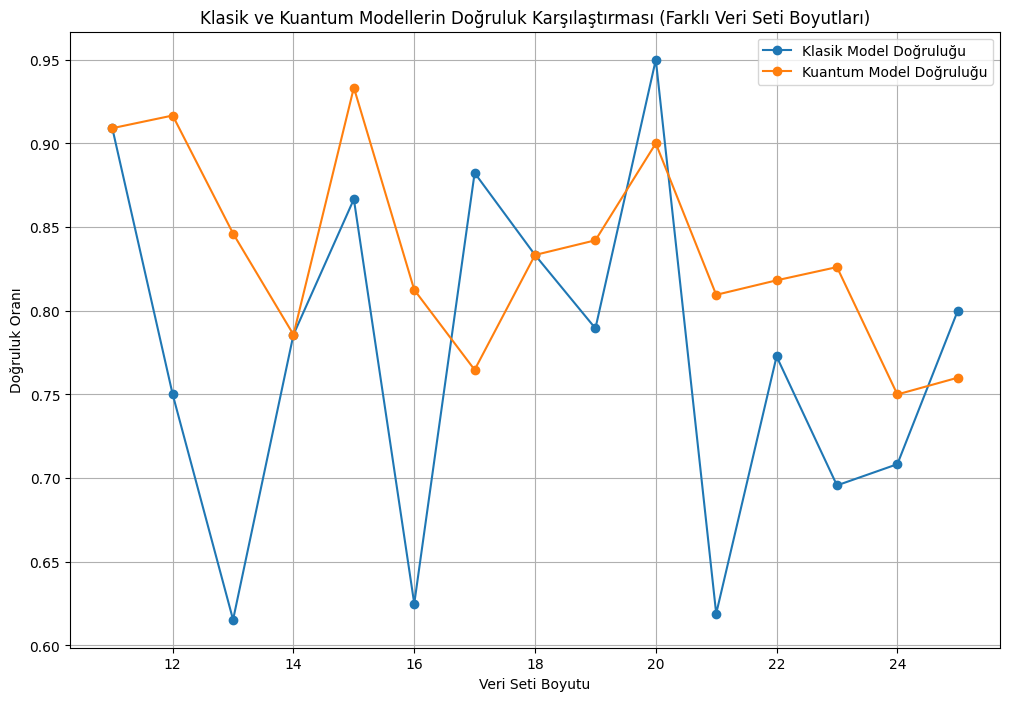

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

np.random.seed(42)

# Define the dataset sizes
n_values = range(11, 26)

classic_accuracies = []
quantum_accuracies = []

def calculate_accuracy(conf_matrix):
  """Calculates accuracy from a confusion matrix."""
  return np.trace(conf_matrix) / np.sum(conf_matrix)

for n in n_values:
    # Generate a random dataset (real)
    data_gercek = {
        'id': range(1, n + 1),
        'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
        'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
        'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
        'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
        'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
        'gercek_suclu': np.random.choice([0, 1], n)
    }

    # Generate a random dataset (court)
    data_mahkeme = {
        'id': range(1, n + 1),
        'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
        'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
        'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
        'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
        'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
        'mahkeme_karari': np.random.choice([0, 1], n)  # 0: Suçsuz, 1: Suçlu
    }

    df_gercek = pd.DataFrame(data_gercek)
    df_mahkeme = pd.DataFrame(data_mahkeme)

    # Convert categorical variables to numerical values
    combined_df = pd.concat([df_mahkeme, df_gercek])
    combined_encoded = pd.get_dummies(combined_df, columns=['vatandaslik', 'cinsiyet', 'suc'], drop_first=True)

    # Splitting DataFrames
    df_mahkeme_encoded = combined_encoded.iloc[:n]
    df_gercek_encoded = combined_encoded.iloc[n:]

    # Filling missing values
    df_mahkeme_encoded = df_mahkeme_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
    df_gercek_encoded = df_gercek_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Creating training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu']), df_mahkeme_encoded['mahkeme_karari'], test_size=0.2, random_state=42)

    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training the classical logistic regression model
    classic_model = LogisticRegression()
    classic_model.fit(X_train_scaled, y_train)

    # Creating a quantum kernel
    feature_dim = X_train.shape[1]
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

    # Training the QSVC model
    quantum_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_scaled, y_train)

    # Making predictions for the dataset
    y_pred_all_classic = classic_model.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))
    y_pred_all_quantum = qsvc.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))

    # Confusion Matrix for Classical Model
    conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)

    # Confusion Matrix for Quantum Model
    conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)

    # Calculating Accuracy Rates
    classic_accuracy = calculate_accuracy(conf_matrix_all_classic)
    quantum_accuracy = calculate_accuracy(conf_matrix_all_quantum)

    # Adding Accuracy Rates to Lists
    classic_accuracies.append(classic_accuracy)
    quantum_accuracies.append(quantum_accuracy)

# Visualizing Accuracy Rates
plt.figure(figsize=(12, 8))
plt.plot(n_values, classic_accuracies, label='Classical Model Accuracy', marker='o')
plt.plot(n_values, quantum_accuracies, label='Kuantum Model Accuracy', marker='o')
plt.title('Comparison of Classical and Quantum Models' Accuracy (Different Dataset Sizes)')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy Rate')
plt.legend()
plt.grid(True)
plt.show()
